## Term 4 Capstone

Julia Martin and Cassie Chou

In [23]:
import geopandas as gpd
import pandas as pd
import altair as alt
import folium
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

Read in data from Open Baltimore API 2024 911 Calls for Service

In [3]:
calls = pd.read_csv("911_Calls_for_Service_2024.csv")
calls.head()

callKey            callDateTime       priority district  \
0  10CC9DA965929F12  2024/01/01 06:16:00+00  Non-Emergency       SE   
1  10CC9DA96592A321  2024/01/01 06:33:00+00  Non-Emergency       ND   
2  10CC9DA96592B7B9  2024/01/01 08:01:00+00  Non-Emergency       CD   
3  10CC9DA96592BCBA  2024/01/01 08:23:00+00  Non-Emergency       CD   
4  10CC9DA96592DFE2  2024/01/01 10:53:00+00            Low       SD   

        description  callNumber  incidentLocation  \
0   NOISE COMPLAINT  P240011042   3600 PULASKI HY   
1       Private Tow  P240011065   5000 DENMORE AV   
2    PRKG COMPLAINT  P240011183    1400 ANCHOR ST   
3    PRKG COMPLAINT  P240011224   1900 EASTERN AV   
4  CHECK WELL-BEING  P240011605  1600 MARSHALL ST   

                        location          Neighborhood PoliceDistrict  ...  \
0   3600 PULASKI HY BALTIMORE MD   Baltimore Highlands   Southeastern  ...   
1   5000 DENMORE AV BALTIMORE MD  Central Park Heights   Northwestern  ...   
2    1400 ANCHOR ST BALTIMORE MD             Riverside       Southern  ...   
3   1900 EASTERN AV BALTIMORE MD           Fells Point   Southeastern  ...   
4  1600 MARSHALL ST BALTIMORE MD       South Baltimore       Southern  ...   

   CouncilDistrict  SheriffDistricts    Community_Statistical_Areas  \
0              1.0                D6  Orangeville/East Highlandtown   
1              6.0                D1      Pimlico/Arlington/Hilltop   
2             11.0                D7      Inner Harbor/Federal Hill   
3              1.0                D6                    Fells Point   
4             11.0                D7      Inner Harbor/Federal Hill   

          Census_Tracts      VRIZones  ZIPCode  NeedsSync  IsDeleted  \
0  Census Tract 2604.04           NaN  21224.0          0          0   
1  Census Tract 2718.02  Northwestern  21215.0          0          0   
2     Census Tract 2402           NaN  21230.0          0          0   
3      Census Tract 203           NaN  21231.0          0          0   
4     Census Tract 2302           NaN  21230.0          0          0   

                                   HashedRecord ESRI_OID  
0  Kitomt4UpJkCoRg0jBbL41PKw1//fHtb9aCjz23s2A0=        1  
1  9AmT5HCrkqTZ8webGYDs+VbQDpTXZ0+lJyL3O+iQ5v4=        2  
2  WHIVLB5k+BOGyUmlCPUzCKKr4Bg4f6S4NwrvbgqMkZ0=        3  
3  Bvouy/qh83Ejj/1V3Q0AuFs3tnChlZAY4lYsW0Korrs=        4  
4  Jo2YzEoa5g+q9cmpQdYzipvP3sQxBYSXg95Rd/97RdM=        5  

[5 rows x 21 columns]

Read in geo data for community statistical areas

In [77]:
csa_data = gpd.read_file("csa_shapes.shp")
csa_data.head()

CSA2010  incm_bl    mdn_ncm  vhcl_bl    prcnt__  \
0      Allendale/Irvington/S. Hilton        1   46005.60        1  34.902498   
1    Beechfield/Ten Hills/West Hills        0   59248.52        0  12.661031   
2                      Belair-Edison        1   51016.16        0  22.756892   
3  Brooklyn/Curtis Bay/Hawkins Point        1   40253.11        0  22.901064   
4                             Canton        0  149999.00        0   5.452196   

   has_str                                  addrs_1  \
0        0                                     None   
1        1  4624 Edmondson Ave, Baltimore, MD 21229   
2        1      2401 Belair Rd, Baltimore, MD 21213   
3        0                                     None   
4        1      2610 Boston St, Baltimore, MD 21224   

                                addrs_2 addrs_3 addrs_4  ...  strnm_3  \
0                                  None    None    None  ...     None   
1                                  None    None    None  ...     None   
2  4001 Erdman Ave, Baltimore, MD 21213    None    None  ...     None   
3                                  None    None    None  ...     None   
4                                  None    None    None  ...     None   

   strnm_4     hfai15  hf_ctgr  hfa_bln  nmbr_c_  prrty_l  id  \
0     None   7.526316      Low        1        3   Medium   1   
1     None  10.400000   Medium        0        1      Low   2   
2     None   8.227273      Low        1        3   Medium   3   
3     None   8.793103      Low        1        2      Low   4   
4     None  15.200000   Medium        0        1      Low   5   

                                                 url  \
0  https://bniajfi.org/community/Allendale_Irving...   
1  https://bniajfi.org/community/Beechfield_Ten%2...   
2       https://bniajfi.org/community/Belair-Edison/   
3  https://bniajfi.org/community/Brooklyn_Curtis%...   
4               https://bniajfi.org/community/Canton   

                                            geometry  
0  POLYGON ((-76.65726 39.276, -76.65726 39.276, ...  
1  POLYGON ((-76.69479 39.30201, -76.69465 39.301...  
2  POLYGON ((-76.56761 39.32636, -76.56746 39.326...  
3  MULTIPOLYGON (((-76.58867 39.21283, -76.58876 ...  
4  POLYGON ((-76.5714 39.28441, -76.57138 39.2841...  

[5 rows x 30 columns]

In [78]:
# unique values in CSA_2010 in calls
unique_csa = calls['Community_Statistical_Areas'].unique()
unique_csa

calls['priority'].unique()

array(['Non-Emergency', 'Low', 'Medium', 'High', 'Emergency',
       'Out of Service'], dtype=object)

CSA vs. Call Priority (Heat Map) 

In [79]:
# subset calls data where priority is out of service
calls_out_of_service = calls[calls['priority'] == 'Out of Service']
calls_out_of_service.head()

# create new column for call priority code
calls['priority_code'] = np.select(
    [calls['priority'] == 'Non-Emergency', calls['priority'] == 'Low', calls['priority'] == 'Medium', calls['priority'] == 'High', calls['priority'] == 'Emergency', calls['priority'] == 'Out of Service'],
    [1, 2, 3, 4, 5, 0]
)

# aggregate calls by CSA and sum of priority code and total number of calls
calls_agg = calls.groupby('Community_Statistical_Areas').agg(
    total_calls=('priority_code', 'count'),
    total_priority=('priority_code', 'sum')
).reset_index()
calls_agg.head()

calls_agg['priority_score'] = calls_agg['total_priority'] / calls_agg['total_calls']
calls_agg.head()

Community_Statistical_Areas  total_calls  total_priority  \
0      Allendale/Irvington/S. Hilton        37703           58148   
1    Beechfield/Ten Hills/West Hills        21162           30614   
2                      Belair-Edison        41501           60339   
3  Brooklyn/Curtis Bay/Hawkins Point        57421           85067   
4                             Canton         9856           15959   

   priority_score  
0        1.542265  
1        1.446650  
2        1.453917  
3        1.481461  
4        1.619217

In [ ]:
# merge calls_agg with csa_data
csa_data = csa_data.merge(calls_agg, left_on='CSA2010', right_on='Community_Statistical_Areas', how='left')
csa_data.head()


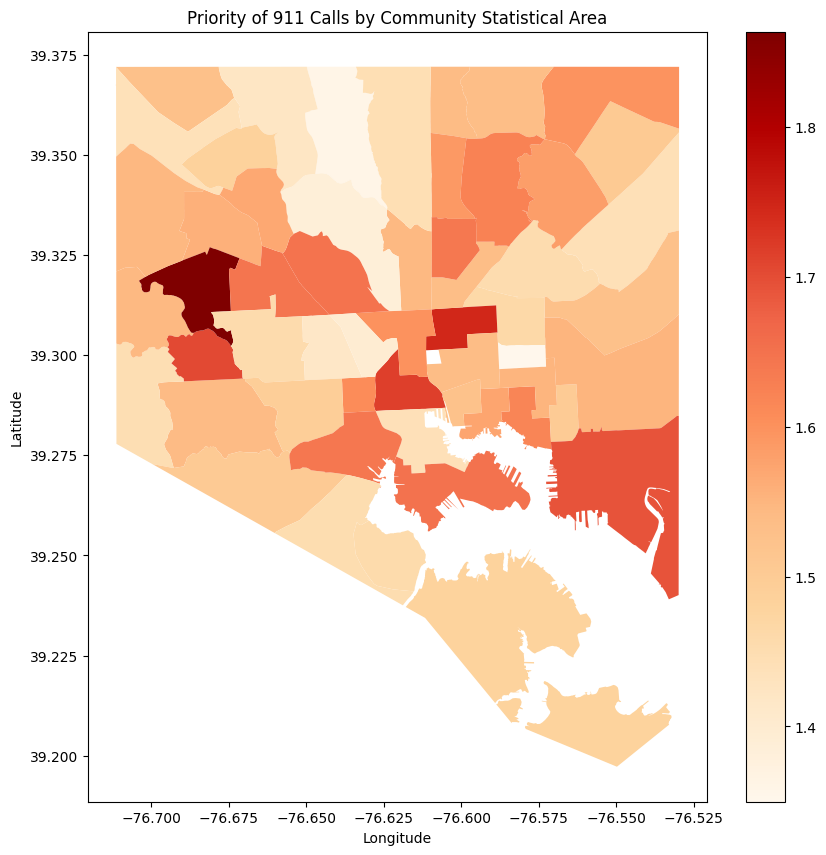

In [29]:
# make a plot of the CSAs
csa_data.plot(column ='priority_score', cmap='OrRd',legend = True, figsize=(10, 10))
plt.title("Priority of 911 Calls by Community Statistical Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Recreate Plot in Plotly

In [107]:
fig1 = px.choropleth_map(
    csa_data,
    geojson=csa_data.geometry,
    locations=csa_data.index,
    color='priority_score',
    color_continuous_scale='OrRd',
    map_style="carto-positron",
    zoom=9.8,
    center={"lat": 39.2905, "lon": -76.6104},
    opacity=0.5,
    labels={"CSA2010": 'CSA', 'priority_score': 'Average Priority'},
    hover_name="CSA2010",  # Main label for hover
    hover_data={
        "priority_score": True
    },
).update_traces(hovertemplate=None)  # Disable default hover template

fig1.update_layout(
    title = " Priority of 911 Calls by Community Statistical Area",
    title_x = 0.5,
    annotations=[
        dict(
            text="1 = Non-Emergency, 2 = Low, 3 = Medium, 4 = High, 5 = Emergency",  # Add your subtitle here
            x=0.5,  # Center the subtitle
            y=-.1,  # Position below the title
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12, color="gray") # Customize font size and color
        )]
)

#fig1.update_geos(fitbounds="locations", visible=False)
fig1.show()

CSA vs. Calls per 1000 people (Heat Map) 

In [112]:
# read in data with population
population_data = pd.read_csv("Total_Population.csv")

# merge with csa_data
csa_data = csa_data.merge(population_data, left_on='CSA2010', right_on='CSA2010', how='left')

# create new column for total calls per 1000 people
csa_data['calls_per_1000'] = (csa_data['total_calls'] / csa_data['tpop20']) * 1000


In [114]:
fig1 = px.choropleth_map(
    csa_data,
    geojson=csa_data.geometry,
    locations=csa_data.index,
    color='calls_per_1000',
    color_continuous_scale='OrRd',
    map_style="carto-positron",
    zoom=9.8,
    center={"lat": 39.2905, "lon": -76.6104},
    opacity=0.5,
    labels={"CSA2010": 'CSA', 'calls_per_1000': 'Annual Calls per 1000 People'},
    hover_name="CSA2010",  # Main label for hover
    hover_data={
        "calls_per_1000": True
    },
).update_traces(hovertemplate=None)  # Disable default hover template

fig1.update_layout(
    title = "Call Density by Community Statistical Area",
    title_x = 0.5,
)

#fig1.update_geos(fitbounds="locations", visible=False)
fig1.show()